# Iris Segmentation in Pytorch
***In this notebook we are going to implement VNET architechture for Iris Segmentation***

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
## Importing the necessary datasets ##

import os

from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms.functional import resize 
from torch.utils.data import DataLoader , Dataset
from torchvision.utils import make_grid , save_image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

With all the packages imported its time to get our hands dirty with the project.

It is always better to visualize the dataset to get a taste of what it is.

We are going to utilize PIL and matplotlib for this purpose.

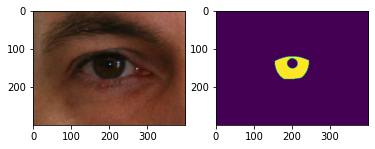

In [43]:
## Visualizing image and mask ##

## Opening the image and mask images ##
img = Image.open('/content/gdrive/MyDrive/final_year_project/CLASSES_400_300_Part1/C1_S1_I1.tiff').convert('RGB')
img_mask = Image.open('/content/gdrive/MyDrive/final_year_project/train/ubiris2_1/ubiris/OperatorA_C1_S1_I1.tiff').convert('L') ## To extract only the content ##

## Converting them into arrays ##
img_arr = np.array(img) / 255.
mask_arr = np.array(img_mask) / 255.

## Plotting the image ##
plt.subplot(1 , 2 , 1)
plt.imshow(img_arr)

## Plotting the mask ##
plt.subplot(1 , 2 , 2)
plt.imshow(mask_arr)

plt.show()

So we can sense the way we need to repurpose our dataset to feed data to our model, which is the main building block of this project.

In the subsequent cells we are going to implement the dataset for our project and we need to do the following things.

* [ ] Create a dataset class which inherits from the pytorch dataset module.
* [ ] Initialize the constructor for the class which takes the image and mask path.
* [ ] Override the __getitem__method which outputs a set of data and label by taking in an index.
* [ ] Override the __len__ method to determine the length of the dataset.

In [44]:
## Creating the custom dataset ##

class BacteriaDataset(Dataset):
    
    def __init__(self , img_path , mask_path):
        self.base_path = '/content/gdrive/MyDrive/final_year_project'
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_list = os.listdir(os.path.join(self.base_path , img_path))
        self.mask_list = os.listdir(os.path.join(self.base_path , mask_path))
        self.dataset_len = len(self.img_list)
        
    def __getitem__(self , idx):
        cycle_idx = idx % self.dataset_len
        
        img = Image.open(os.path.join(os.path.join(self.base_path , self.img_path) , self.img_list[cycle_idx])).convert('RGB')
        img_mask = Image.open(os.path.join(os.path.join(self.base_path , self.mask_path) , self.mask_list[cycle_idx])).convert('L') 
        
        aug = transforms.Compose([
            transforms.Resize((64 , 64)),
            transforms.ToTensor()
        ])
        
        img_tensor = aug(img)
        mask_tensor = aug(img_mask)
        
        
        return img_tensor , mask_tensor
    
    def __len__(self):
        return self.dataset_len

In [45]:
## Instantiating the dataset ##

bacteria_data = BacteriaDataset('CLASSES_400_300_Part1' , 'train_jpg/train_mask')

print('The length of the dataset is :' , len(bacteria_data))

The length of the dataset is : 50


We can see that the code ran without error.

But it is of the best interest to visualize an example for error checking. So lets do that.

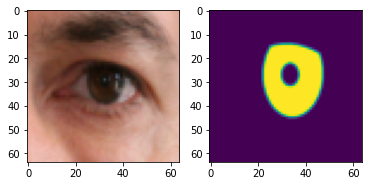

In [46]:
## Visualizing a data point ##

np.random.seed(47)

rand_idx = int(np.random.randint(0 , len(bacteria_data) , size = 1))

img , mask = bacteria_data[rand_idx]

#img = img.squeeze(0)
#mask = mask.squeeze(0)

## Plotting the image ##
plt.subplot(1 , 2 , 1)
plt.imshow(img.permute(1 , 2 , 0))

## Plotting the mask ##
plt.subplot(1 , 2 , 2)
plt.imshow(np.squeeze(mask.permute(1 , 2, 0)))

plt.show()

Now with the dataset out of the way, it would be really unreasonable to put the entire dataset to the model.

Hence, comes the requirements of a DataLoader. It takes in the dataset as input and spits out batches of data for updation of weight via mini-batches.

In [47]:
## Instantiating DataLoader ##

bacteria_dl = DataLoader(bacteria_data , batch_size = 16 , shuffle = True)

print('The length of the dataloader is:' , len(bacteria_dl))

The length of the dataloader is: 4


Its always better to visualize a set of the dataset to get better insight.

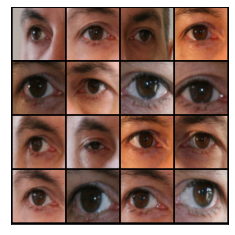

In [48]:
## Displaying images ##

for img , mask in bacteria_dl:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(img  , 4).permute(1 , 2 , 0))
    #plt.imshow(make_grid(mask , 4).permute(1 , 2 , 0))
    plt.show()
    break

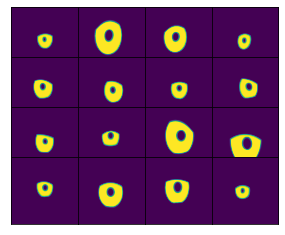

In [49]:
## Displaying mask ##

for img , mask in bacteria_dl:
    for i in range(len(mask)):
        plt.subplot(4 , 4 , i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.squeeze(mask[i].permute(1 , 2 , 0)))
    plt.subplots_adjust(wspace=-0.5, hspace=-0.25)
    plt.show()
    break

Now we have created the dataloader.

But, it is not enough! Why not? Well the dataloader utilizes cpu for its working. But that is quite inefficient. We need to push it to GPU. Hence we need to write some code which would do that for us and make the process much more efficient.

In [50]:
## GPU transfer utility functions ##

def check_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def transfer_data(data , device):
    if isinstance(data , (list , tuple)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device)

Now we have sorted the utility functions.

Now next what we do is create our custom dataloader which utilizes GPU.

In [51]:
## GPU Dataloader ##

class GPUDataLoader():
    
    def __init__(self , dl , device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield transfer_data(batch , self.device)
    
    def __len__(self):
        return len(self.dl)

In [52]:
## Instantiating our dataloader ##

device = check_device()

dl_bacteria = GPUDataLoader(bacteria_dl , device)

Okay! The dataloader is instantiated.

Lets check some test cases such that we can be assured of the requirements.

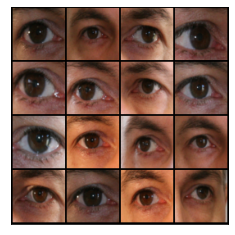

In [53]:
## Displaying images ##

for img , mask in dl_bacteria:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(np.squeeze(make_grid(img.to('cpu')  , 4).permute(1 , 2 , 0)))
    #plt.imshow(make_grid(mask , 4).permute(1 , 2 , 0))
    plt.show()
    break

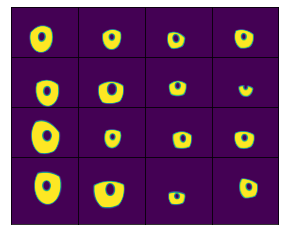

In [54]:
## Displaying mask ##

for img , mask in dl_bacteria:
    for i in range(len(mask)):
        plt.subplot(4 , 4 , i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.squeeze(mask.to('cpu')[i].permute(1 , 2 , 0)))
    plt.subplots_adjust(wspace=-0.5, hspace=-0.25)
    plt.show()
    break

Okay. So our dataloader is working excellently.

So, now we are all set for the final part.

Our main VNET structure.

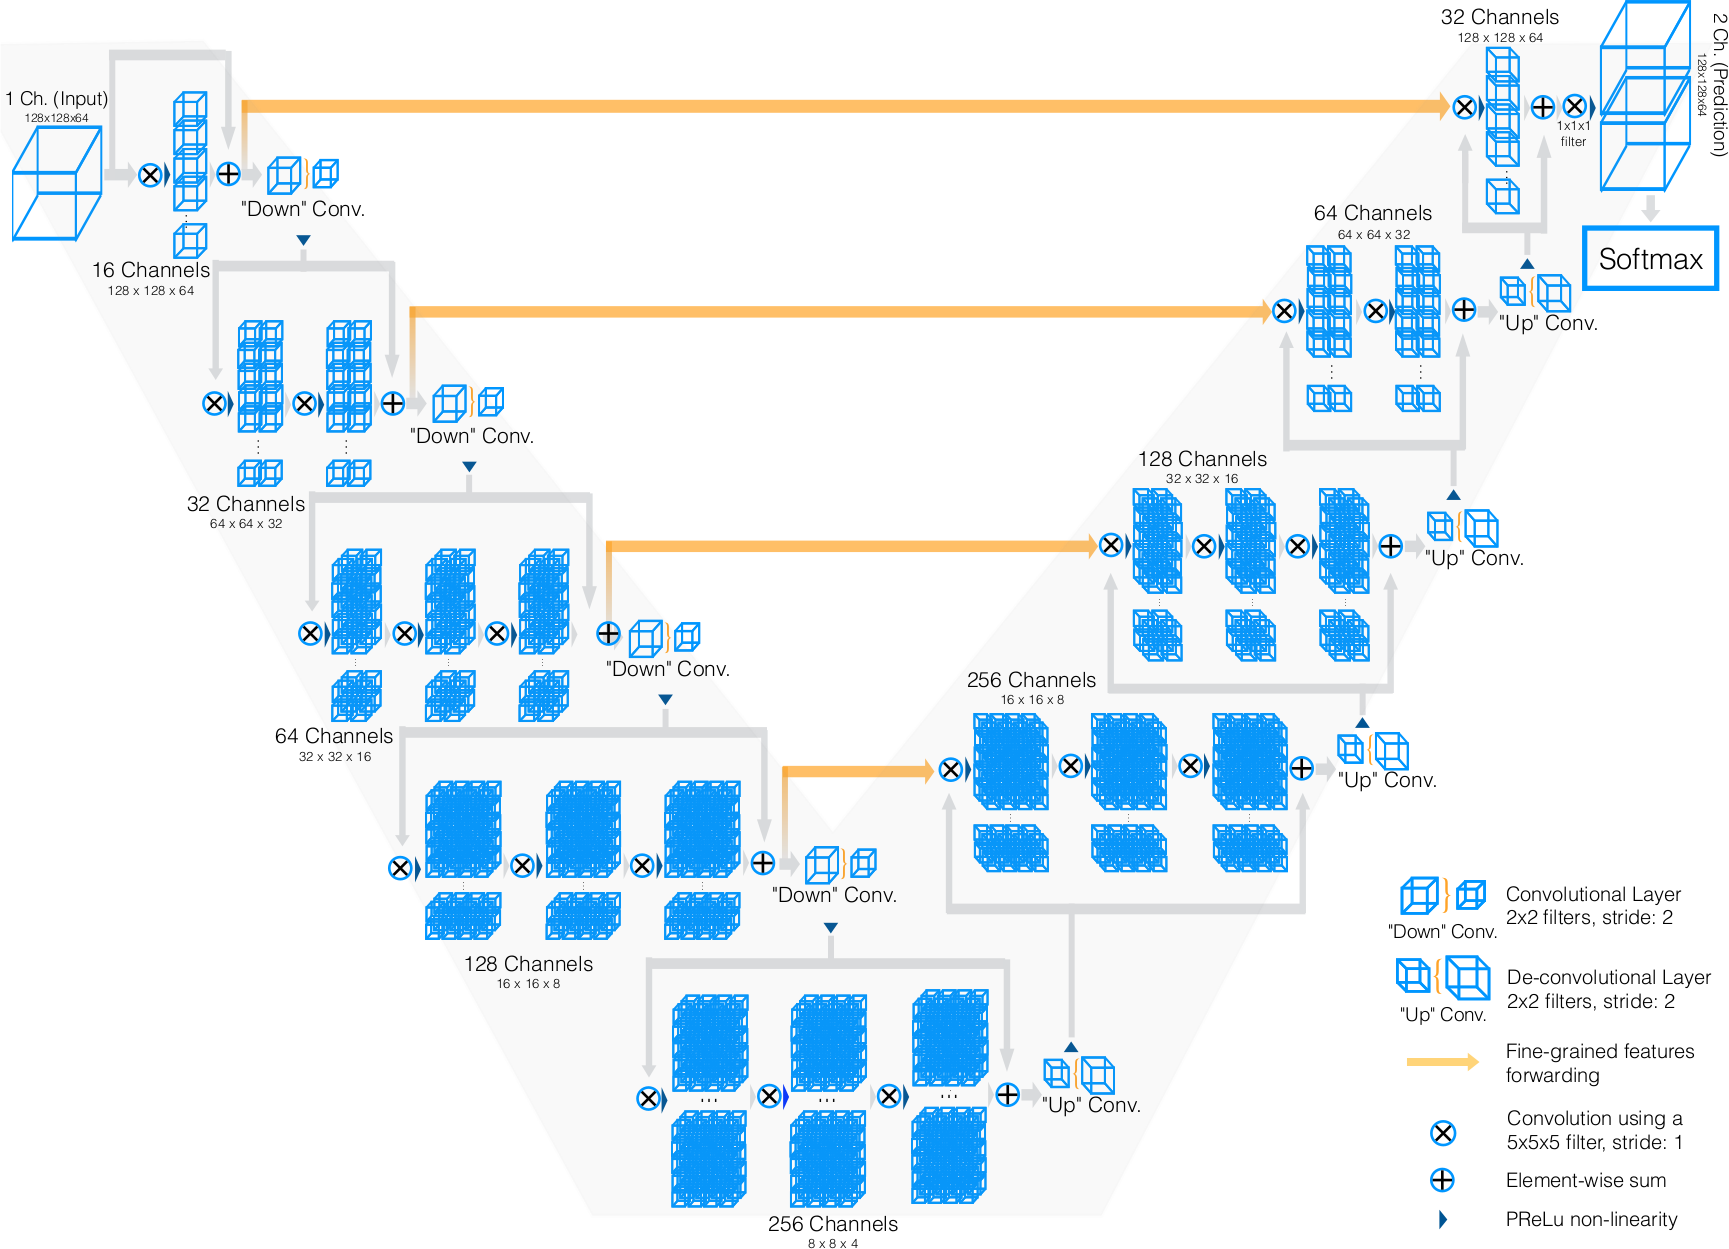

The main architecture of VNET is given above-- from the original paper.

What we are going to do is improvise a bit and carry on.

Our starting dimension is 64,64,3.

So lets model our VNET.

In [55]:
## Defining Unet Architecture ##
class VnetConv(nn.Module):
    
    def __init__(self , in_dim , out_dim , kernel_size = 3 , padding = 1 , stride = 1):
        
        super().__init__()
        
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels = in_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True),
                            nn.Conv2d(in_channels = out_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True),nn.Conv2d(in_channels = out_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True),nn.Conv2d(in_channels = out_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True))
        
    def forward(self , inp):
        return self.conv_block(inp)

class irisVNET(nn.Module):
    
    def __init__(self , in_dim = 3 , out_dim = 1 , filters = [64 , 128 , 256 , 512]):
        super().__init__()
        self.filters = filters
        self.out_dim = out_dim
        self.max_pool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        
        self.down_block = nn.ModuleList([])
        self.up_block = nn.ModuleList([])
        
        for each_filter in self.filters:
            self.down_block.append(VnetConv(in_dim = in_dim , out_dim = each_filter))
            in_dim = each_filter
            
        for each_filter in reversed(self.filters):
            self.up_block.append(nn.ConvTranspose2d(in_channels = each_filter * 2 , out_channels = each_filter , 
                                                    kernel_size = 2 , stride= 2))
            self.up_block.append(VnetConv(in_dim = each_filter * 2 , out_dim = each_filter))
            self.up_block.append(VnetConv(in_dim = each_filter  , out_dim = each_filter))
            self.up_block.append(VnetConv(in_dim = each_filter  , out_dim = each_filter))
        
        self.bridge_block = VnetConv(in_dim = self.filters[-1] , 
                                      out_dim = self.filters[-1] * 2)
        
        self.final_layer = nn.Conv2d(in_channels = self.filters[0] , out_channels = self.out_dim,
                                     kernel_size = 1)
        
        
    def forward(self , x):
        
        down_conv_out = []
        
        for layer in self.down_block:
            x = layer(x) 
            down_conv_out.append(x)
            x = self.max_pool(x)
            
        x = self.bridge_block(x)
        
        down_conv_out = down_conv_out[::-1]
            
        for layer_num in range(0 , len(self.up_block) , 4):
            
            x = self.up_block[layer_num](x)
            skip_conn = down_conv_out[layer_num // 4]
            
            if x.shape != skip_conn.shape:
                
                x = resize(x , size = skip_conn.shape[2:])
                
            
            x = torch.cat((x , skip_conn) , dim = 1)
            
            x = self.up_block[layer_num + 1](x)
            x = self.up_block[layer_num + 2](x)
            x = self.up_block[layer_num + 3](x)
            
        x = self.final_layer(x)
        
        return x

In [56]:
## Instantiating our model ##

model = irisVNET()

model = model.to(device)

Now our model is done and dusted.

Lets initialize our loss function and optimizer.

In [57]:
## Initializing loss function and optimizer ##

loss_fn = nn.BCEWithLogitsLoss()

optim = torch.optim.Adam(params = model.parameters() , lr = 3e-4)

We are going to now move on to the training loop.

Epoch : 1 / 100 --> Loss : 0.614
Epoch : 2 / 100 --> Loss : 0.537
Epoch : 3 / 100 --> Loss : 0.460
Epoch : 4 / 100 --> Loss : 0.381


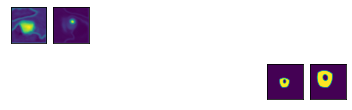

Epoch : 5 / 100 --> Loss : 0.349
Epoch : 6 / 100 --> Loss : 0.325
Epoch : 7 / 100 --> Loss : 0.334
Epoch : 8 / 100 --> Loss : 0.314
Epoch : 9 / 100 --> Loss : 0.314


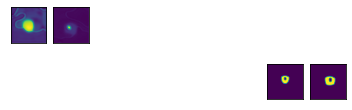

Epoch : 10 / 100 --> Loss : 0.311
Epoch : 11 / 100 --> Loss : 0.299
Epoch : 12 / 100 --> Loss : 0.282
Epoch : 13 / 100 --> Loss : 0.292
Epoch : 14 / 100 --> Loss : 0.309


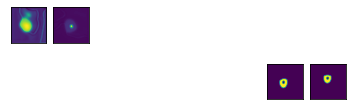

Epoch : 15 / 100 --> Loss : 0.268
Epoch : 16 / 100 --> Loss : 0.265
Epoch : 17 / 100 --> Loss : 0.341
Epoch : 18 / 100 --> Loss : 0.268
Epoch : 19 / 100 --> Loss : 0.239


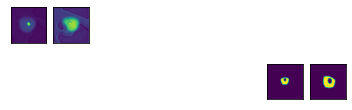

Epoch : 20 / 100 --> Loss : 0.265
Epoch : 21 / 100 --> Loss : 0.234
Epoch : 22 / 100 --> Loss : 0.243
Epoch : 23 / 100 --> Loss : 0.227
Epoch : 24 / 100 --> Loss : 0.237


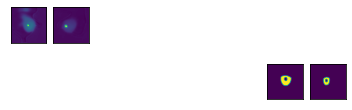

Epoch : 25 / 100 --> Loss : 0.237
Epoch : 26 / 100 --> Loss : 0.217
Epoch : 27 / 100 --> Loss : 0.226
Epoch : 28 / 100 --> Loss : 0.274
Epoch : 29 / 100 --> Loss : 0.206


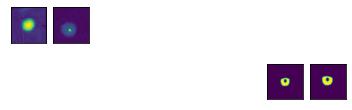

Epoch : 30 / 100 --> Loss : 0.233
Epoch : 31 / 100 --> Loss : 0.235
Epoch : 32 / 100 --> Loss : 0.197
Epoch : 33 / 100 --> Loss : 0.190
Epoch : 34 / 100 --> Loss : 0.213


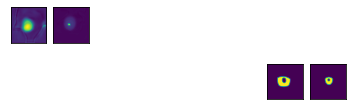

Epoch : 35 / 100 --> Loss : 0.193
Epoch : 36 / 100 --> Loss : 0.218
Epoch : 37 / 100 --> Loss : 0.198
Epoch : 38 / 100 --> Loss : 0.183
Epoch : 39 / 100 --> Loss : 0.172


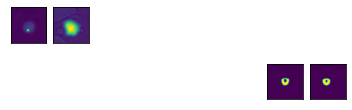

Epoch : 40 / 100 --> Loss : 0.200
Epoch : 41 / 100 --> Loss : 0.183
Epoch : 42 / 100 --> Loss : 0.201
Epoch : 43 / 100 --> Loss : 0.188
Epoch : 44 / 100 --> Loss : 0.204


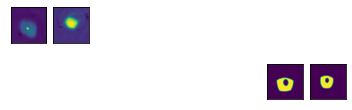

Epoch : 45 / 100 --> Loss : 0.219
Epoch : 46 / 100 --> Loss : 0.173
Epoch : 47 / 100 --> Loss : 0.201
Epoch : 48 / 100 --> Loss : 0.161
Epoch : 49 / 100 --> Loss : 0.158


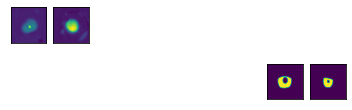

Epoch : 50 / 100 --> Loss : 0.163
Epoch : 51 / 100 --> Loss : 0.193
Epoch : 52 / 100 --> Loss : 0.197
Epoch : 53 / 100 --> Loss : 0.142
Epoch : 54 / 100 --> Loss : 0.149


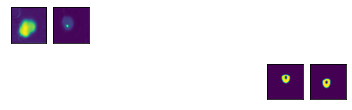

Epoch : 55 / 100 --> Loss : 0.185
Epoch : 56 / 100 --> Loss : 0.142
Epoch : 57 / 100 --> Loss : 0.161
Epoch : 58 / 100 --> Loss : 0.214
Epoch : 59 / 100 --> Loss : 0.152


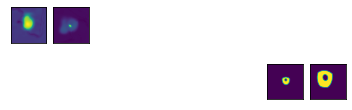

Epoch : 60 / 100 --> Loss : 0.199
Epoch : 61 / 100 --> Loss : 0.148
Epoch : 62 / 100 --> Loss : 0.147
Epoch : 63 / 100 --> Loss : 0.181
Epoch : 64 / 100 --> Loss : 0.130


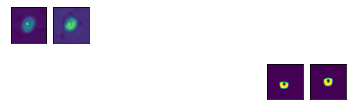

Epoch : 65 / 100 --> Loss : 0.146
Epoch : 66 / 100 --> Loss : 0.131
Epoch : 67 / 100 --> Loss : 0.121
Epoch : 68 / 100 --> Loss : 0.118
Epoch : 69 / 100 --> Loss : 0.133


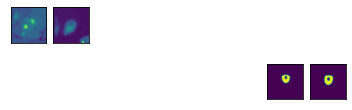

Epoch : 70 / 100 --> Loss : 0.189
Epoch : 71 / 100 --> Loss : 0.128
Epoch : 72 / 100 --> Loss : 0.143
Epoch : 73 / 100 --> Loss : 0.250
Epoch : 74 / 100 --> Loss : 0.135


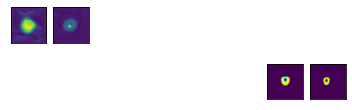

Epoch : 75 / 100 --> Loss : 0.120
Epoch : 76 / 100 --> Loss : 0.154
Epoch : 77 / 100 --> Loss : 0.128
Epoch : 78 / 100 --> Loss : 0.155
Epoch : 79 / 100 --> Loss : 0.118


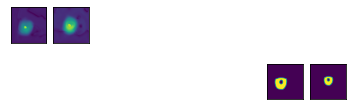

Epoch : 80 / 100 --> Loss : 0.127
Epoch : 81 / 100 --> Loss : 0.139
Epoch : 82 / 100 --> Loss : 0.233
Epoch : 83 / 100 --> Loss : 0.166
Epoch : 84 / 100 --> Loss : 0.113


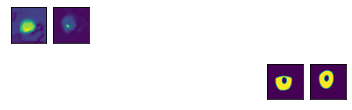

Epoch : 85 / 100 --> Loss : 0.209
Epoch : 86 / 100 --> Loss : 0.142
Epoch : 87 / 100 --> Loss : 0.130
Epoch : 88 / 100 --> Loss : 0.122
Epoch : 89 / 100 --> Loss : 0.198


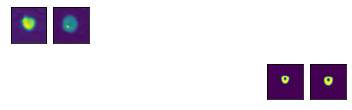

Epoch : 90 / 100 --> Loss : 0.127
Epoch : 91 / 100 --> Loss : 0.120
Epoch : 92 / 100 --> Loss : 0.101
Epoch : 93 / 100 --> Loss : 0.107
Epoch : 94 / 100 --> Loss : 0.099


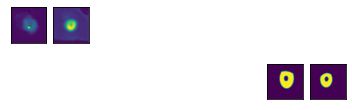

Epoch : 95 / 100 --> Loss : 0.190
Epoch : 96 / 100 --> Loss : 0.177
Epoch : 97 / 100 --> Loss : 0.162
Epoch : 98 / 100 --> Loss : 0.141
Epoch : 99 / 100 --> Loss : 0.097


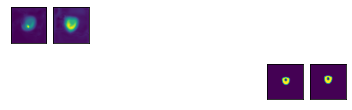

Epoch : 100 / 100 --> Loss : 0.100


In [58]:
## Training loop ##

num_epochs = 100

for epoch in range(num_epochs):
    
    for img , mask in dl_bacteria:
        
        model.train()
        
        pred = model(img)
        
        loss = loss_fn(pred , mask)
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
    
    model.eval()
    
    if (epoch + 1) % 5 == 0:
        for i in range(len(pred)):
            plt.subplot(4 , 8 , i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(np.squeeze(pred[i].detach().to('cpu').permute(1 , 2 , 0)))
            plt.subplot(4 , 8 , i+15)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(np.squeeze(mask[i].to('cpu').permute(1 , 2 , 0)))
        
        plt.show()
    
    print('Epoch : {} / {} --> Loss : {:.3f}'.format(epoch + 1 , num_epochs , loss.item()))